In [1]:
import os, glob, time, datetime
import json
import numpy as np
from numpy import genfromtxt
from sqlite3_database_plot import *
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
import itertools
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [2]:
# function returing chip number and date time str from file path
def chip_time_stamp(data):
    chip = data.split('chip_')[1].split(".")[0].split('_')
    return chip[0], chip[1]+'_'+chip[2]

def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)


def get_max_width(channels, err_counts):
    max_width_by_ch = []
    second_max_width_by_ch = []
    err_wrapped=np.concatenate([err_counts,err_counts[:0]])
    for ch in range(channels):
        x = err_wrapped[:,ch]
        phases = consecutive(np.argwhere(x==0).flatten())
        sizes = [np.size(a) for a in phases]
        max_width = np.max(sizes)
        sizes.remove(max_width)
        try:
            second_max_width = np.max(sizes)
        except:
            second_max_width = 0
        max_width_by_ch.append(max_width)
        second_max_width_by_ch.append(second_max_width)
    return np.array([max_width_by_ch,second_max_width_by_ch])

### Filtering the dublicate data keeping the latest one 

In [41]:
file_paths = np.sort(glob.glob('data_ECON-D-P1v2/*'))

# Create a dictionary to store the latest timestamp for each chip number
chip_latest_timestamps = {}

# Iterate through the file paths
for file_path in file_paths:
    # Extract chip number and timestamp
    chip_number, timestamp_str = chip_time_stamp(file_path)
    

    # Convert timestamp string to datetime object
    timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d_%H:%M:%S')

    # Update the dictionary with the latest timestamp for each chip number
    if chip_number not in chip_latest_timestamps or timestamp > chip_latest_timestamps[chip_number]:
        chip_latest_timestamps[chip_number] = timestamp

        
chip_latest_timestamps       
        
        
# Create a new list with only the file paths having the latest timestamp for each chip number
filtered_file_paths = []
for file_path in file_paths:
    chip_number, timestamp_str = chip_time_stamp(file_path)
    timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d_%H:%M:%S')
    
    if chip_number in chip_latest_timestamps.keys() and timestamp in chip_latest_timestamps.values():
        filtered_file_paths.append(file_path)
    
print(len(filtered_file_paths))


199


### Function used to make plots diretly only giveing the chip number

data_ECON-D-P1v2/report_chip_750_2024-01-18_14:57:46.json


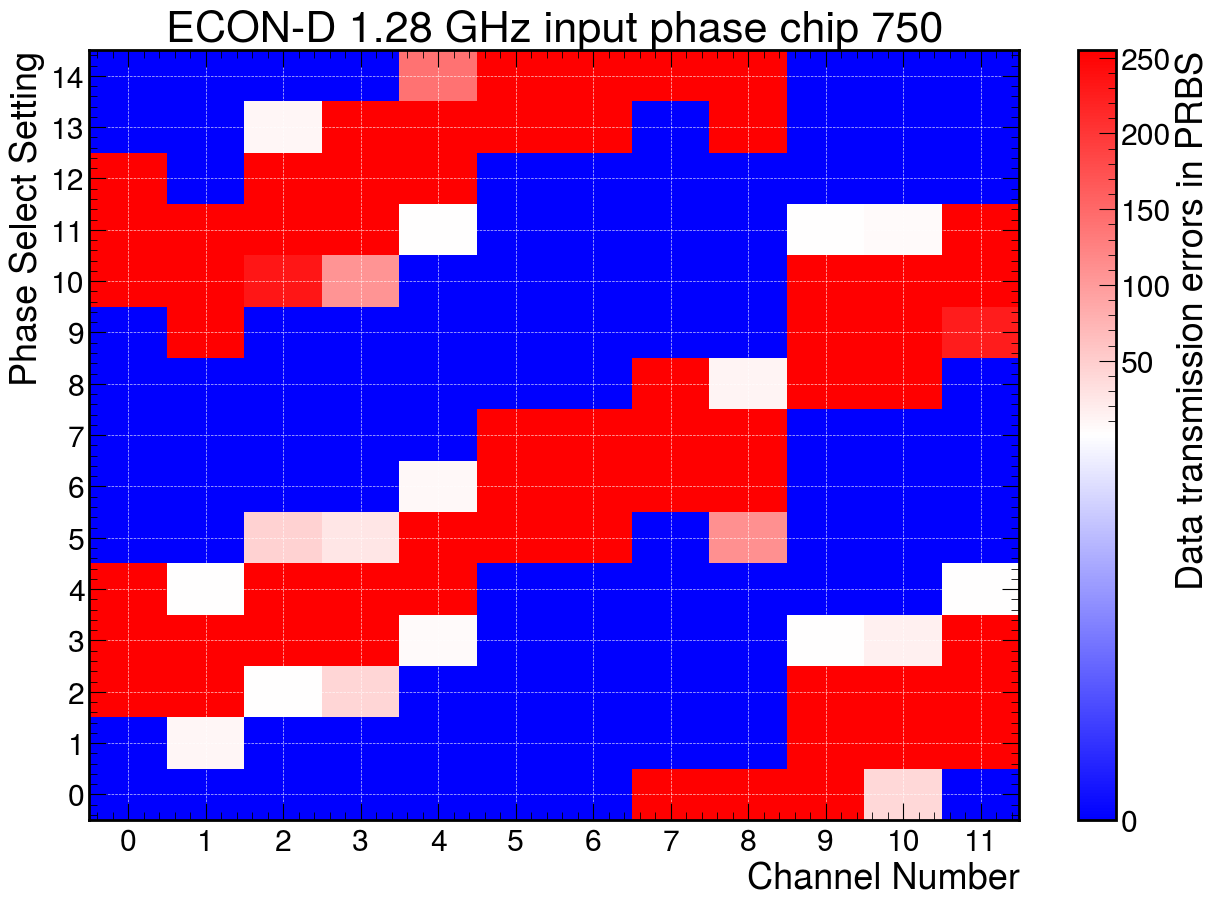

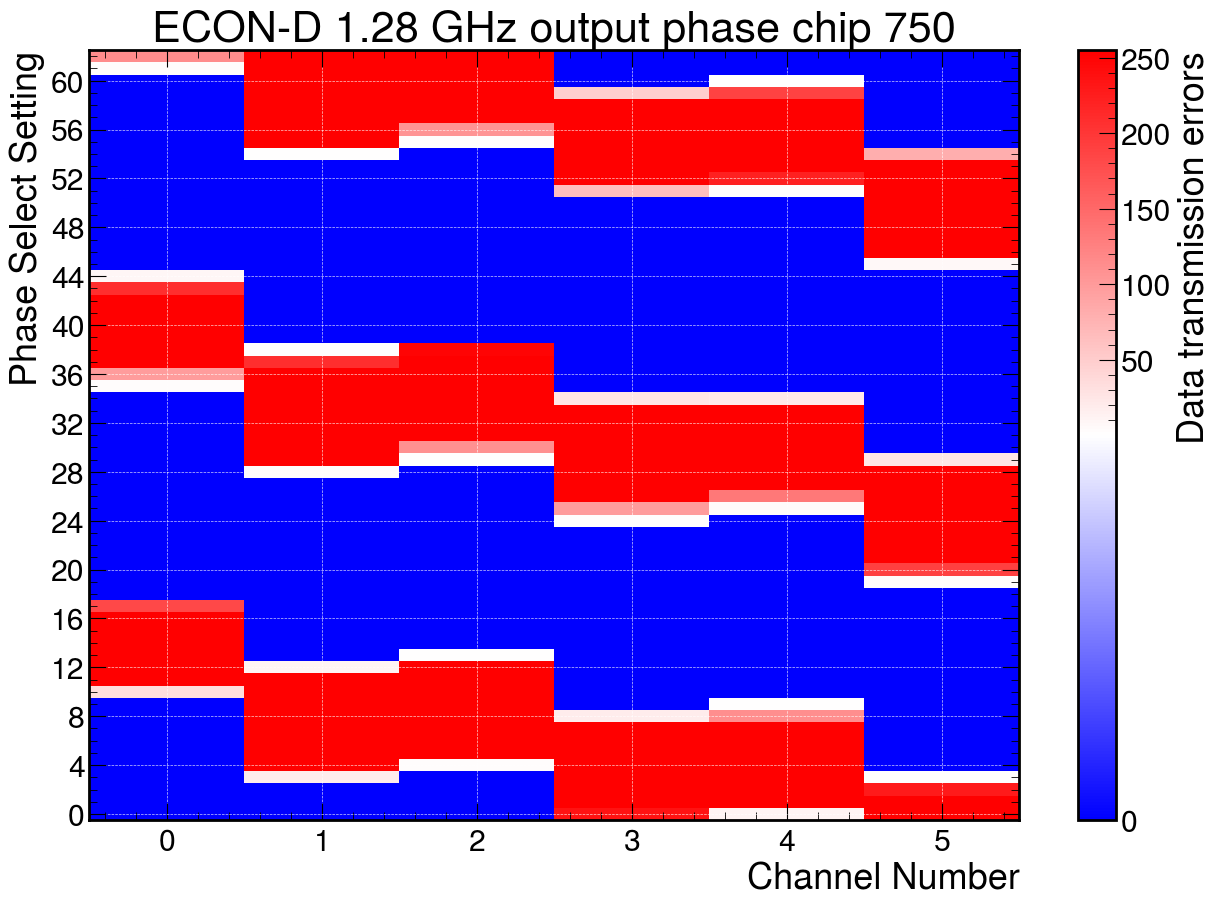

In [21]:
def phase_scan_eRx(chip_number=750,out_dir="PLOTS_ECOND_P1_V2"):
    for f in range(len(filtered_file_paths)):
        chip, _ = chip_time_stamp(filtered_file_paths[f])
        if int(chip)==chip_number:
            print(filtered_file_paths[f])
            with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
                J = json.load(jsonfile)

            for t in J['tests']:
                if t['nodeid'] == 'test_io.py::test_ePortRXPRBS':
                    break
            else:
                raise ValueError("Couldn't find test_ePortRXPRBS")
            eRX_errcounts = np.array(t['metadata']['eRX_errcounts'])
            a,b=np.meshgrid(np.arange(12),np.arange(15))
            norm = mcolors.TwoSlopeNorm(vmin=0, vmax = 255, vcenter=.9)
            plt.figure(figsize=(15, 10))
            plt.hist2d(a.flatten(),b.flatten(),weights=eRX_errcounts.flatten(),bins=(np.arange(13)-0.5,np.arange(16)-0.5),cmap='bwr',norm = norm);
            plt.colorbar().set_label(label='Data transmission errors in PRBS')
            plt.yticks(np.arange(0,15,1))
            plt.xticks(np.arange(0,12,1))
            plt.grid(color='white', linestyle='--', linewidth=.5)
            plt.title(f"ECON-D 1.28 GHz input phase chip {chip_number}")
            plt.ylabel('Phase Select Setting')
            plt.xlabel('Channel Number')
            # odir= out_dir 
            # if not os.path.isdir(odir):
            #     os.makedirs(odir)
            # plt.savefig(f'{odir}/phase_scan_eRx_plot_chip_{chip_number}_Econ{suffix}.png',facecolor='w',dpi=300)
            # plt.close()
            plt.show()

            
            
def phase_scan_eTx(chip_number=750,out_dir='PLOTS'):
    for f in range(len(filtered_file_paths)):
        chip, _ = chip_time_stamp(filtered_file_paths[f])
        if int(chip)==chip_number:
            with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
                J = json.load(jsonfile)
            for t in J['tests']:
                if t['nodeid'] == 'test_io.py::test_eTX_delayscan':
                    break
            else:
                raise ValueError("Couldn't find test_eTX_delayscan")
            error_counts_eTx = np.array(t['metadata']['eTX_errcounts']).T
    error_counts_eTx = np.minimum(error_counts_eTx, 255)
    norm = mcolors.TwoSlopeNorm(vmin=0, vmax = 255, vcenter=0.1)
    plt.figure(figsize=(15, 10))
    a,b=np.meshgrid(np.arange(6),np.arange(63))
    plt.hist2d(a.flatten(),b.flatten(),weights=error_counts_eTx.flatten(),bins=(np.arange(7)-0.5,np.arange(64)-0.5),cmap='bwr',norm=norm);
    plt.xticks(np.arange(0,6,1))
    plt.colorbar().set_label(label='Data transmission errors')
    plt.yticks(np.arange(0,64,4))    
    plt.grid(color='white', linestyle='--', linewidth=.5)
    plt.title(f"ECON-D 1.28 GHz output phase chip {chip_number}")
    plt.ylabel('Phase Select Setting')
    plt.xlabel('Channel Number')
    plt.ylabel('Phase Select Setting')
    plt.xlabel('Channel Number')
#     odir= out_dir 
#     if not os.path.isdir(odir):
#         os.makedirs(odir)
#    plt.savefig(f'{out_dir}/phase_scan_eTx_chip_{chip_number}_Econ{suffix}.png',dpi=300,facecolor='w')
#     plt.close()
    plt.show()

phase_scan_eRx(chip_number=750,out_dir="PLOTS_ECOND_P1_V2")
phase_scan_eTx(chip_number=750,out_dir='PLOTS')

### volin plot for max width eRX

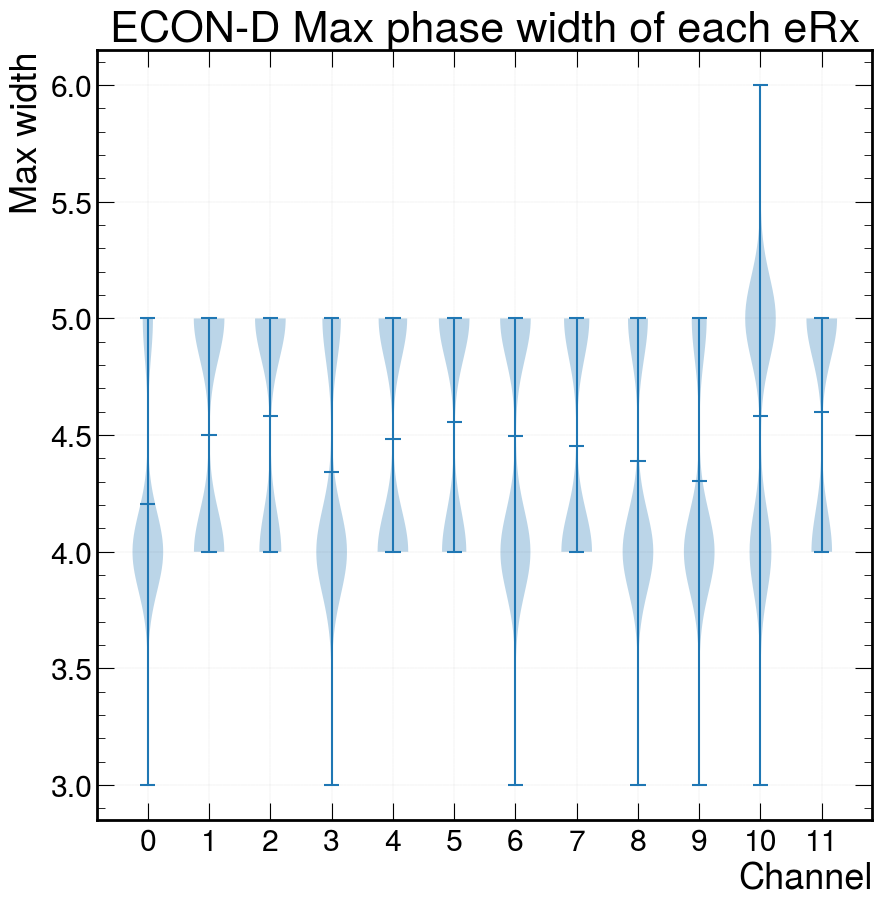

In [22]:
max_width = []
for f in range(len(filtered_file_paths)):
    with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
        J = json.load(jsonfile)

    for t in J['tests']:
        if t['nodeid'] == 'test_io.py::test_ePortRXPRBS':
            break
    else:
        raise ValueError("Couldn't find test_ePortRXPRBS")
    maxwidth = np.array(t['metadata']['maxwidth'])
    max_width.append(maxwidth.tolist())
data = np.array(max_width)
plt.violinplot(data, showmeans=True, showextrema=True)
plt.xticks(range(1,13), ['0','1', '2', '3' ,'4', '5', '6',
                              '7', '8', '9', '10', '11'])
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.title(f"ECON-D Max phase width of each eRx")
plt.grid(color='black', linestyle='--', linewidth=0.05)
plt.ylabel(f'Max width')
plt.xlabel('Channel')
odir= 'PLOTS_ECOND_P1_V2_retested' 
# if not os.path.isdir(odir):
#     os.makedirs(odir)
# plt.savefig(f'{odir}/Max_width_volin_of_all_eRx_Econd.png', dpi=300, facecolor = "w")
plt.show()


### volin plot for second max width eRX

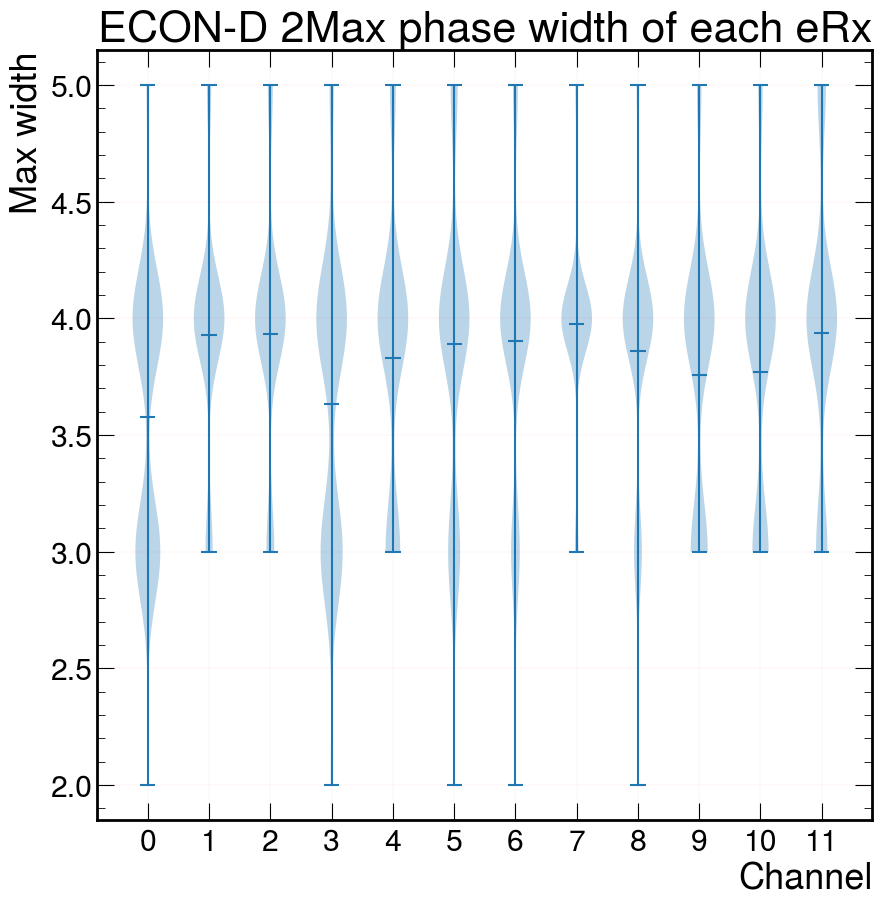

In [23]:
second_max_width = []
for f in range(len(filtered_file_paths)):
    with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
        J = json.load(jsonfile)

    for t in J['tests']:
        if t['nodeid'] == 'test_io.py::test_ePortRXPRBS':
            break
    else:
        raise ValueError("Couldn't find test_ePortRXPRBS")
    second_maxwidth = np.array(t['metadata']['second_max_width'])
    second_max_width.append(second_maxwidth.tolist())
data = np.array(second_max_width)
plt.violinplot(data, showmeans=True, showextrema=True)
plt.xticks(range(1,13), ['0','1', '2', '3' ,'4', '5', '6',
                              '7', '8', '9', '10', '11'])
plt.title(f"ECON-D 2Max phase width of each eRx")
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.grid(color='r', linestyle='--', linewidth=.05)
plt.ylabel(f'Max width')
plt.xlabel('Channel')
odir= odir= 'PLOTS_ECOND_P1_V2_retested'  
# if not os.path.isdir(odir):
#     os.makedirs(odir)
# plt.savefig(f'{odir}/2Max_width_volin_of_all_eRx_Econd.png', dpi=300, facecolor = "w")
plt.show()


In [24]:
max_width = []
for f in range(len(filtered_file_paths)):
    with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
        J = json.load(jsonfile)

    for t in J['tests']:
        if t['nodeid'] == 'test_io.py::test_ePortRXPRBS':
            break
    else:
        raise ValueError("Couldn't find test_ePortRXPRBS")
    maxwidth = t['metadata']['maxwidth']
    max_width.append(maxwidth)
max_width = np.array(max_width)
max_width

array([[5, 4, 4, ..., 5, 5, 4],
       [4, 5, 5, ..., 4, 5, 5],
       [4, 4, 4, ..., 4, 5, 5],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 5, 4, ..., 4, 4, 5],
       [5, 5, 5, ..., 4, 5, 5]])

In [25]:
np.mean(max_width[:,11])

4.597989949748744

###  max with histogran for eTx

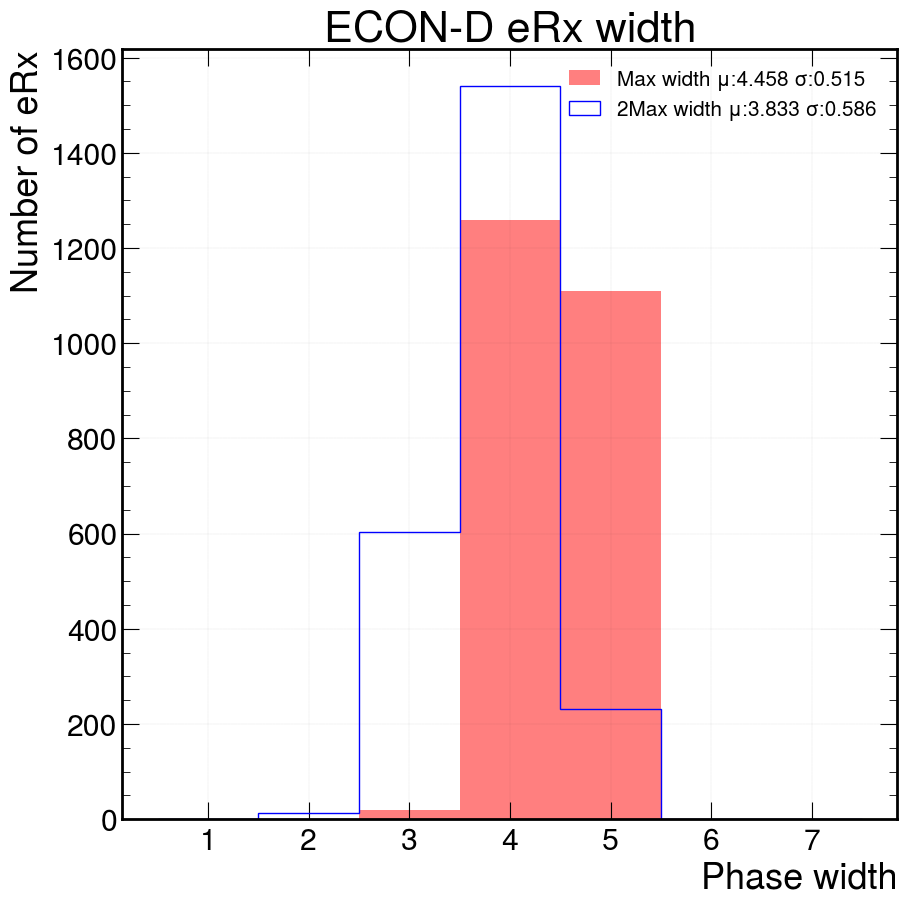

In [26]:
max_width = []
second_max_width = []
for f in range(len(filtered_file_paths)):
    with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
        J = json.load(jsonfile)

    for t in J['tests']:
        if t['nodeid'] == 'test_io.py::test_ePortRXPRBS':
            break
    else:
        raise ValueError("Couldn't find test_ePortRXPRBS")
    maxwidth = t['metadata']['maxwidth']
    max_width.append(maxwidth)
    
    with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
        J = json.load(jsonfile)

    for t in J['tests']:
        if t['nodeid'] == 'test_io.py::test_ePortRXPRBS':
            break
    else:
        raise ValueError("Couldn't find test_ePortRXPRBS")
    second_maxwidth = t['metadata']['second_max_width']
    second_max_width.append(second_maxwidth)
    
max_width = np.array(max_width).flatten()
second_max_width = np.array(second_max_width).flatten()
plt.hist(max_width, bins= np.arange(1,9,1)-0.5,color='r',alpha=0.5,label=f"Max width \u03BC:{np.mean(max_width):.3f} \u03C3:{np.std(max_width):.3f}")
plt.hist(second_max_width, histtype="step", bins= np.arange(1,9,1)-0.5,color='b',label=f"2Max width \u03BC:{np.mean(second_max_width):.3f} \u03C3:{np.std(second_max_width):.3f}")
plt.title(f"ECON-D eRx width")
plt.grid(color='black', linestyle='--', linewidth=.05)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.legend(loc="best",fontsize='15')
plt.ylabel('Number of eRx')
plt.xlabel('Phase width')
odir='PLOTS_ECOND_P1_V2' 
# if not os.path.isdir(odir):
#     os.makedirs(odir)
# plt.savefig(f'{odir}/Phase_width__of_all_eRx_Econd.png', dpi=300, facecolor = "w")
plt.show()


Text(1, 0, 'Phase width')

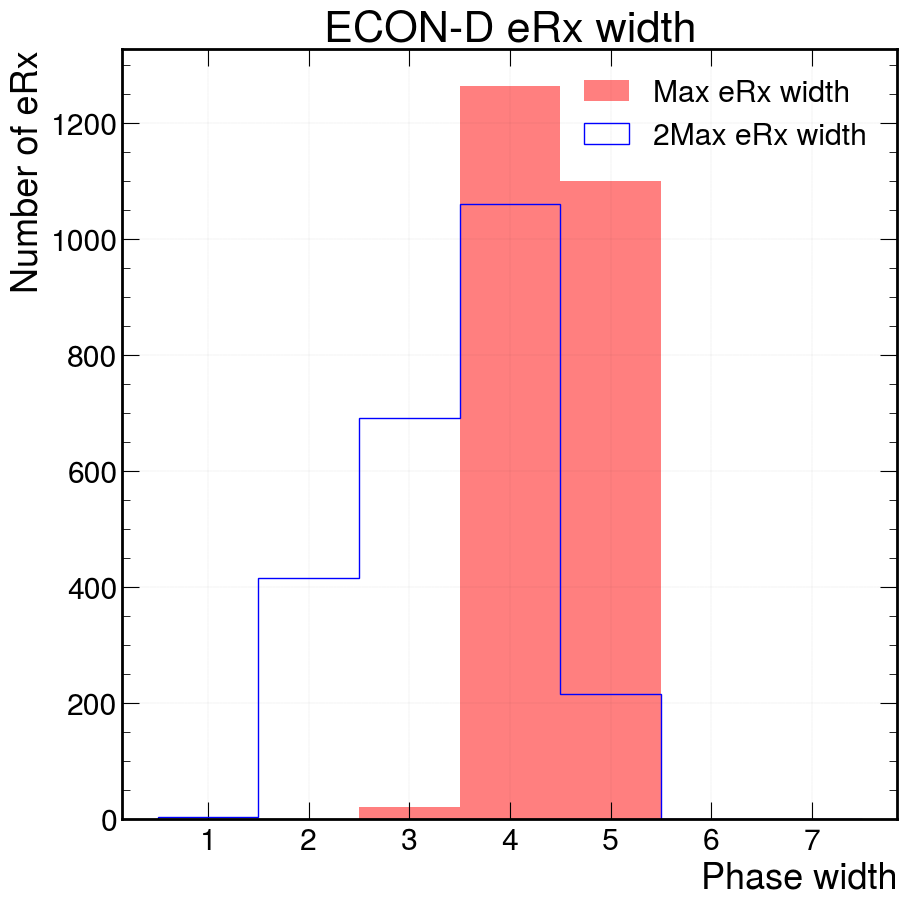

In [27]:
max_width = []
second_max_width =[]
for f in range(len(filtered_file_paths)):
    
    
    with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
        J = json.load(jsonfile)

    for t in J['tests']:
        if t['nodeid'] == 'test_io.py::test_ePortRXPRBS':
            break
    else:
        raise ValueError("Couldn't find test_ePortRXPRBS")
    eRX_errcounts = np.array(t['metadata']['eRX_errcounts'])
    maxwidth, second_maxwidth= get_max_width(12,eRX_errcounts)
    max_width.append(maxwidth.tolist())
    second_max_width.append(second_maxwidth.tolist())

max_width = np.array(max_width).flatten()
second_max_width = np.array(second_max_width).flatten()
plt.hist(max_width, bins= np.arange(1,9,1)-0.5,color='r',alpha=0.5,label="Max eRx width")
plt.hist(second_max_width, histtype="step", bins= np.arange(1,9,1)-0.5,color='b',label="2Max eRx width")
plt.title(f"ECON-D eRx width")
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.grid(color='black', linestyle='--', linewidth=.05)
plt.legend()
plt.ylabel('Number of eRx')
plt.xlabel('Phase width')

### eTX  width volin plot

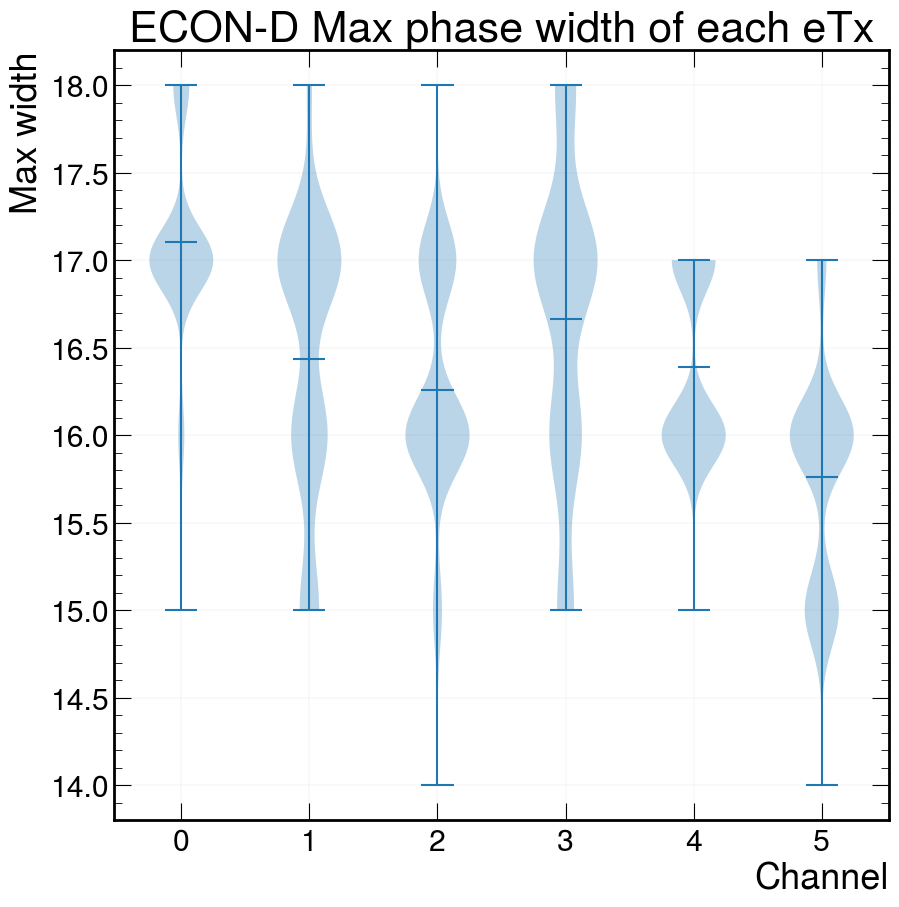

In [28]:
max_width = []
second_max_width =[]
for f in range(len(filtered_file_paths)):
    
    with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
        J = json.load(jsonfile)

    for t in J['tests']:
        if t['nodeid'] == 'test_io.py::test_eTX_delayscan':
            break
    else:
        raise ValueError("Couldn't find test_eTX_delaysca")
    error_counts_eTx = np.array(t['metadata']['eTX_errcounts']).T
    maxwidth, second_maxwidth= get_max_width(6,error_counts_eTx)
    max_width.append(maxwidth.tolist())
    second_max_width.append(second_maxwidth.tolist())
plt.violinplot(np.array(max_width), showmeans=True, showextrema=True)
plt.xticks(range(1,7), ['0','1', '2', '3' ,'4', '5'])
plt.title(f"ECON-D Max phase width of each eTx")
plt.grid(color='black', linestyle='--', linewidth=.05)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.ylabel(f'Max width')
plt.xlabel('Channel')
odir= odir= 'PLOTS_ECOND_P1_V2'  
# if not os.path.isdir(odir):
#     os.makedirs(odir)
# plt.savefig(f'{odir}/Max_width_volin_of_all_eTx_Econd.png', dpi=300, facecolor = "w")
plt.show()





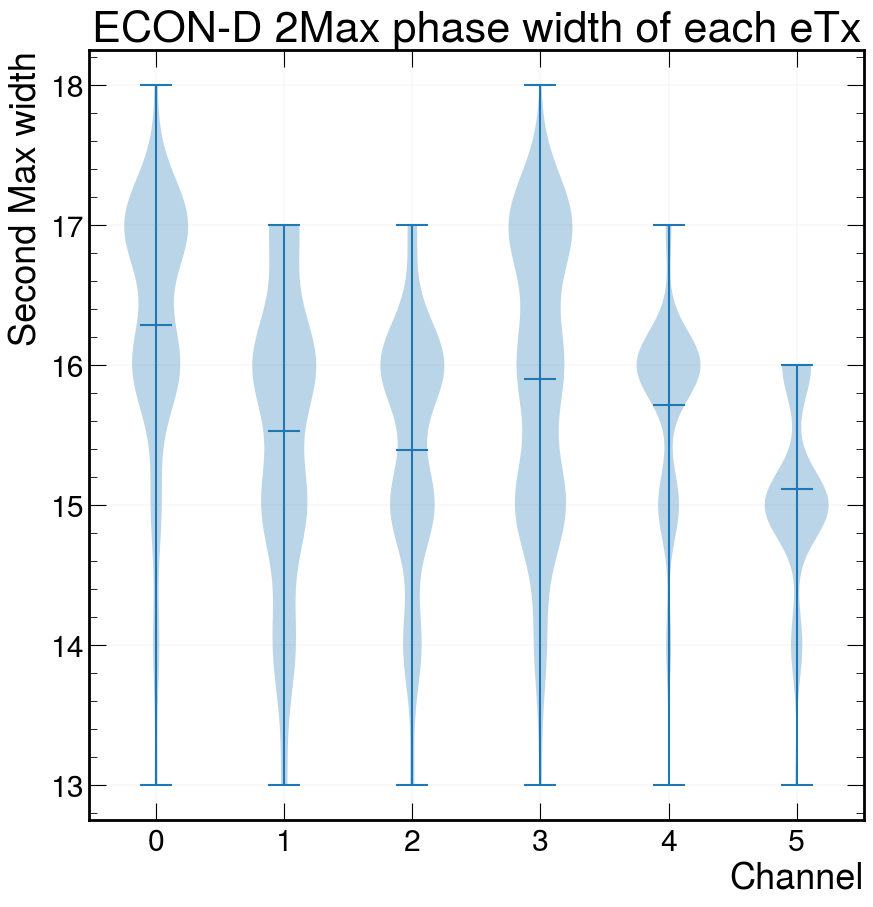

In [29]:
max_width = []
second_max_width =[]
for f in range(len(filtered_file_paths)):
    
    with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
        J = json.load(jsonfile)

    for t in J['tests']:
        if t['nodeid'] == 'test_io.py::test_eTX_delayscan':
            break
    else:
        raise ValueError("Couldn't find test_eTX_delaysca")
    error_counts_eTx = np.array(t['metadata']['eTX_errcounts']).T
    maxwidth, second_maxwidth= get_max_width(6,error_counts_eTx)
    max_width.append(maxwidth.tolist())
    second_max_width.append(second_maxwidth.tolist())


plt.violinplot(np.array(second_max_width), showmeans=True, showextrema=True)
plt.xticks(range(1,7), ['0','1', '2', '3' ,'4', '5'])
plt.title(f"ECON-D 2Max phase width of each eTx")
plt.grid(color='black', linestyle='--', linewidth=.05)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.ylabel(f'Second Max width')
plt.xlabel('Channel')
odir= odir= 'PLOTS_ECOND_P1_V2'  
# if not os.path.isdir(odir):
#     os.makedirs(odir)
# plt.savefig(f'{odir}/2Max_width_volin_of_all_eTx_Econd.png', dpi=300, facecolor = "w")
plt.show()


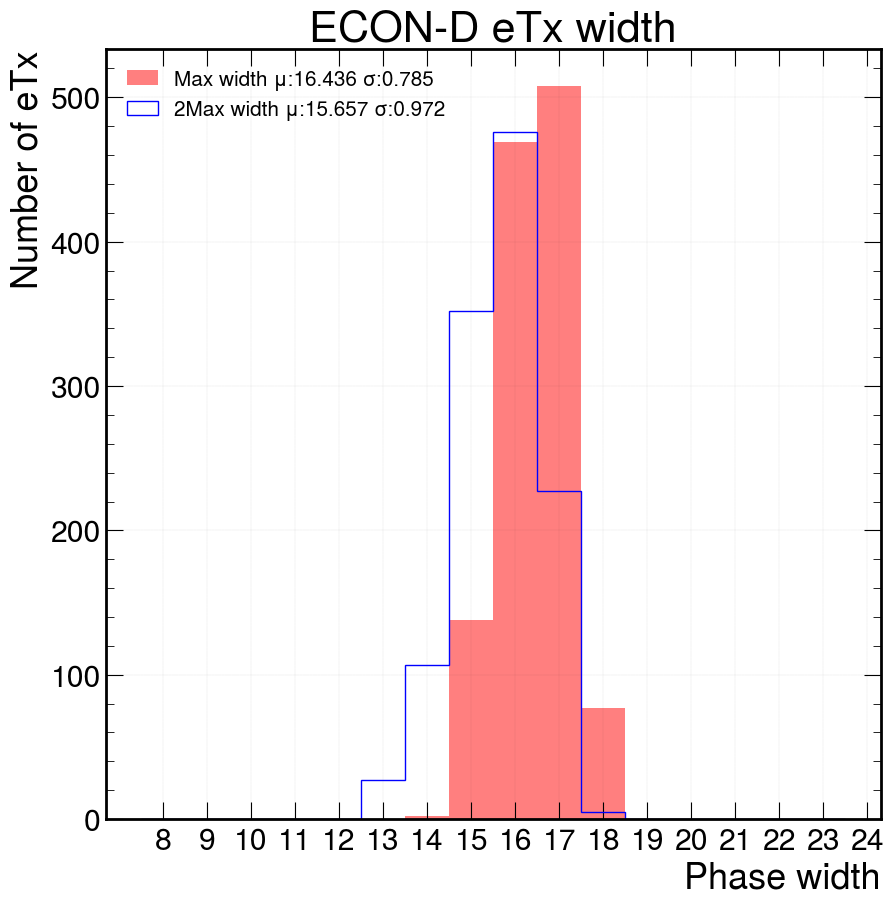

In [30]:
max_width = []
second_max_width =[]
for f in range(len(filtered_file_paths)):
    
    with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
        J = json.load(jsonfile)

    for t in J['tests']:
        if t['nodeid'] == 'test_io.py::test_eTX_delayscan':
            break
    else:
        raise ValueError("Couldn't find test_eTX_delaysca")
    error_counts_eTx = np.array(t['metadata']['eTX_errcounts']).T
    maxwidth, second_maxwidth= get_max_width(6,error_counts_eTx)
    max_width.append(maxwidth.tolist())
    second_max_width.append(second_maxwidth.tolist())

max_width = np.array(max_width).flatten()
second_max_width = np.array(second_max_width).flatten()
plt.hist(max_width, bins= np.arange(8,25,1)-0.5,color='r',alpha=0.5,label=f"Max width \u03BC:{np.mean(max_width):.3f} \u03C3:{np.std(max_width):.3f}")
plt.hist(second_max_width, histtype="step", bins= np.arange(8,25,1)-0.5,color='b',label=f"2Max width \u03BC:{np.mean(second_max_width):.3f} \u03C3:{np.std(second_max_width):.3f}")
plt.xticks(np.arange(8,25,1))
plt.title(f"ECON-D eTx width")
plt.grid(color='black', linestyle='--', linewidth=.05)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.legend(loc='best', fontsize=15)
plt.ylabel('Number of eTx')
plt.xlabel('Phase width')
odir= odir= 'PLOTS_ECOND_P1_V2'
# if not os.path.isdir(odir):
#     os.makedirs(odir)
# plt.savefig(f'{odir}/Phase_width_of_all_eTx_Econd.png', dpi=300, facecolor = "w")

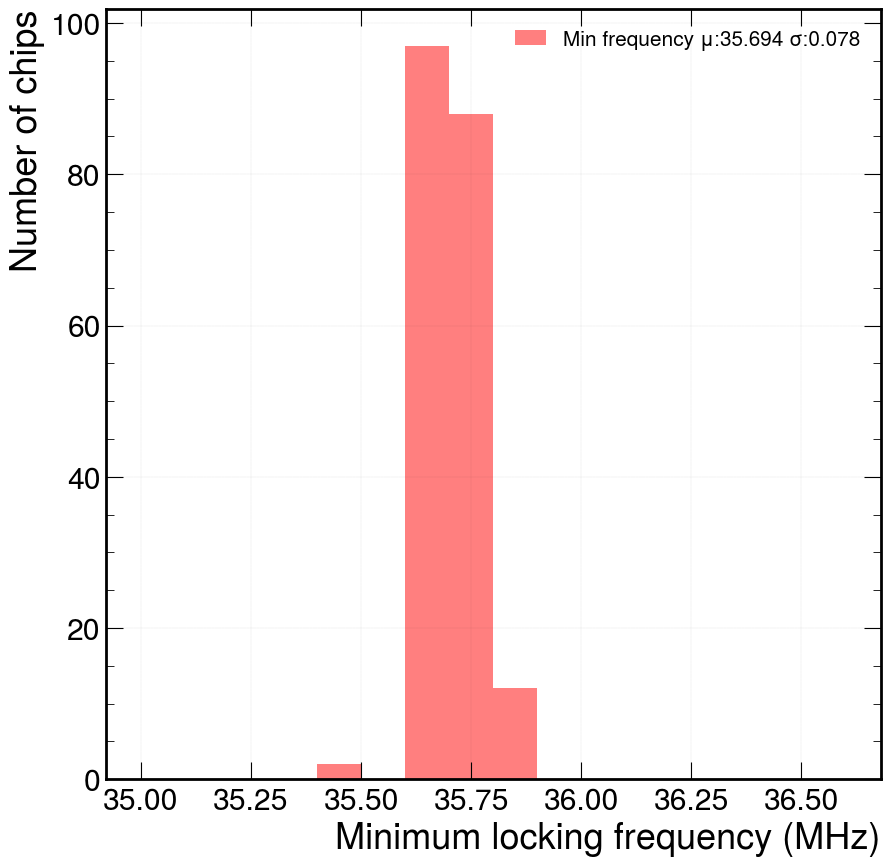

In [31]:
minfreq = []
maxfreq = []
for f in range(len(filtered_file_paths)):
    
    with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
        J = json.load(jsonfile)

    for t in J['tests']:
        if t['nodeid'] == 'test_pll.py::test_pllautolock':
            break
    else:
        raise ValueError("Couldn't find test_eTX_delaysca")
    frequencies_used = np.array(t['metadata']['frequencies_used'])
    pusm_states = np.array(t['metadata']['pusm_states'])
    auto_locks = np.array(t['metadata']['auto_locks'])
    auto_vco = np.array(t['metadata']['auto_vco'])
    min_freq = t['metadata']['min_freq']
    max_freq = t['metadata']['max_freq']
    minfreq.append(min_freq)
    maxfreq.append(max_freq)
plt.hist(minfreq,bins=np.arange(35,36.6,0.1),color='r',alpha=0.5,label=f"Min frequency \u03BC:{np.mean(minfreq):.3f} \u03C3:{np.std(minfreq):.3f}")
plt.xlabel("Minimum locking frequency (MHz)")
plt.ylabel("Number of chips")
plt.grid(color='black', linestyle='--', linewidth=.05)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.legend(loc='best', fontsize=15)
odir= odir= 'PLOTS_ECOND_P1_V2'
# if not os.path.isdir(odir):
#     os.makedirs(odir)
# plt.savefig(f'{odir}/Min_locking_freq_Econd.png', dpi=300, facecolor = "w")

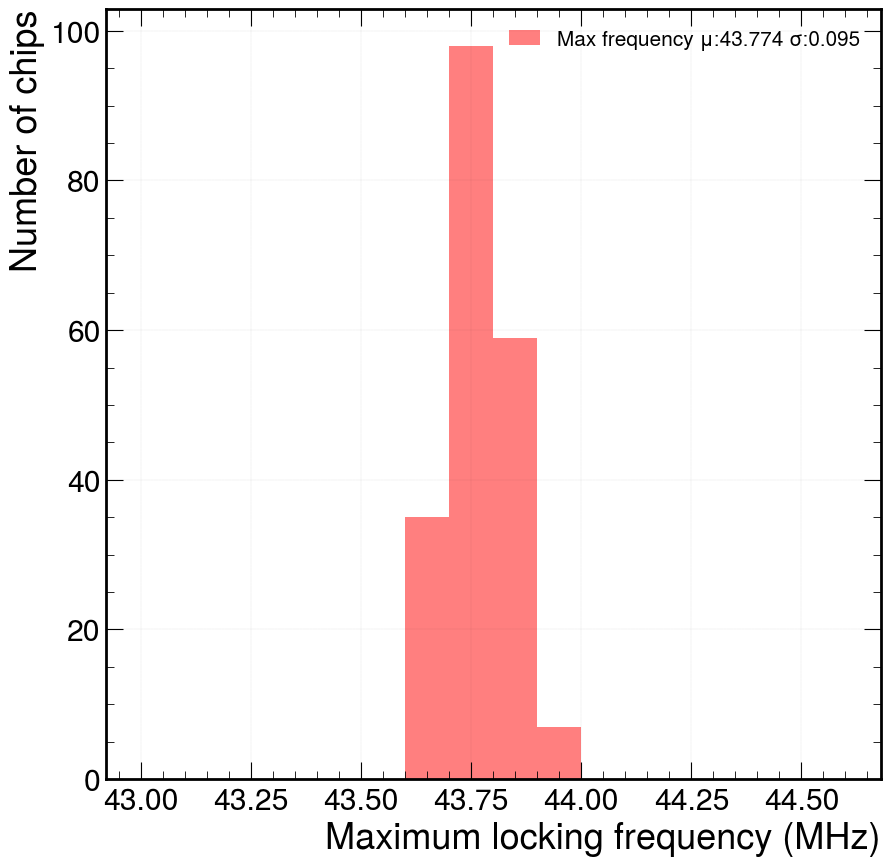

In [32]:
plt.hist(maxfreq,bins=np.arange(43,44.6,0.1),color='r',alpha=0.5,label=f"Max frequency \u03BC:{np.mean(maxfreq):.3f} \u03C3:{np.std(maxfreq):.3f}")
plt.xlabel("Maximum locking frequency (MHz)")
plt.ylabel("Number of chips")
odir= odir= 'PLOTS_ECOND_P1_V2'
plt.legend(loc='best', fontsize=15)
plt.grid(color='black', linestyle='--', linewidth=.05)
# if not os.path.isdir(odir):
#     os.makedirs(odir)
# plt.savefig(f'{odir}/Max_locking_freq_Econd.png', dpi=300, facecolor = "w")

33 data_ECON-D-P1v2/report_chip_807_2024-01-18_14:17:38.json


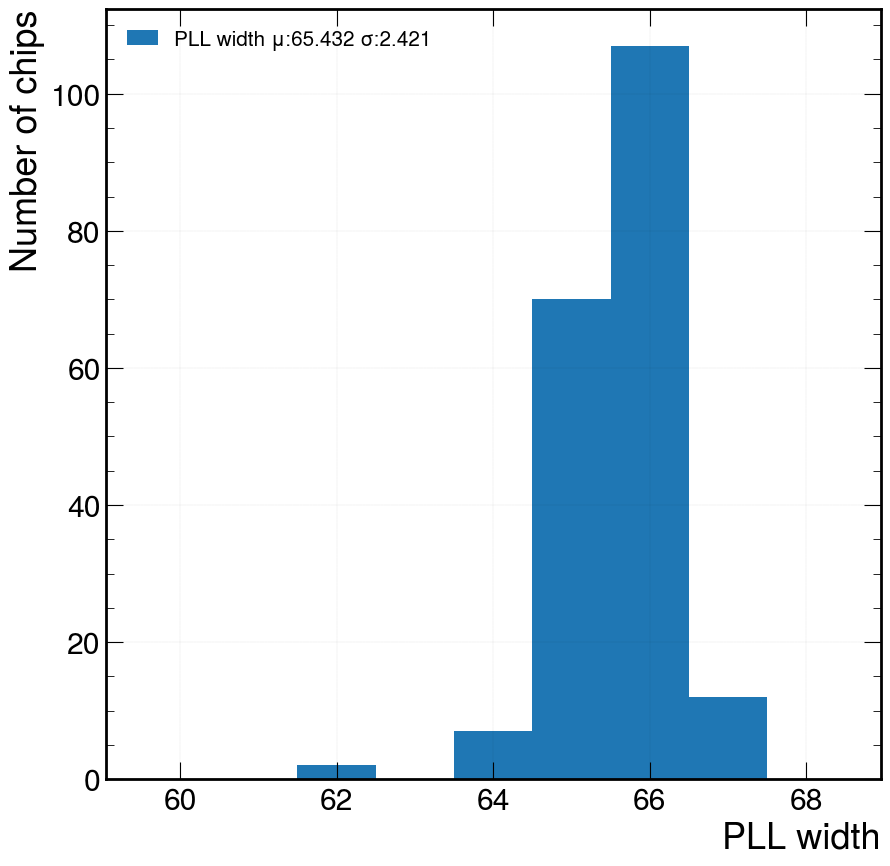

In [33]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

pll_width =[]
for f in range(len(filtered_file_paths)):

    with open(f"{filtered_file_paths[f]}", "r") as jsonfile:
        J = json.load(jsonfile)

    for t in J['tests']:
        if t['nodeid']=='test_pll.py::test_pllautolock':
            break
    #auto_locks = np.array(t['metadata']['auto_locks'])
    state = np.array(t['metadata']['pusm_states'])

    phase = consecutive(np.argwhere(state==8).flatten(), stepsize=1)
    size = [np.size(a) for a in phase]
    pll_width.append(max(size))
    if max(size) < 40: print(max(size),filtered_file_paths[f])
    
plt.hist(pll_width,bins = np.arange(60,70,1)-0.5,label=f"PLL width \u03BC:{np.mean(pll_width):.3f} \u03C3:{np.std(pll_width):.3f}")
plt.xlabel("PLL width")
plt.ylabel("Number of chips")
odir= odir= 'PLOTS_ECOND_P1_V2'
plt.legend(loc='best', fontsize=15)
plt.grid(color='black', linestyle='--', linewidth=.05)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
if not os.path.isdir(odir):
    os.makedirs(odir)
plt.savefig(f'{odir}/pll_width_Econd.png', dpi=300, facecolor = "w")

In [34]:
#failed chip list

In [35]:
file_paths = np.sort(glob.glob('data_ECON-D-P1v2/*'))

# Create a dictionary to store the latest timestamp for each chip number
chip_latest_timestamps = {}

# Iterate through the file paths
for file_path in file_paths:
    
    # Extract chip number and timestamp
    chip_number, timestamp_str = chip_time_stamp(file_path)
    print(chip_number)
     

601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
645
645
645
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
661
661
662
662
663
663
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
690
701
701
701
702
702
703
704
705
706
707
708
709
710
711
712
713
715
716
717
718
719
720
721
722
723
724
724
725
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
742
742
743
744
745
746
746
747
748
749
750
751
752
753
754
755
756
757
758
758
759
760
761
762
763
764
764
765
766
767
768
769
770
771
771
772
773
774
775
776
777
778
779
779
780
781
782
783
784
785
786
787
788
789
790
801
802
803
804
805
806
807
808
809
810
811
812
813
813
814
815
816
817
818
819
820


In [36]:
phase

[array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])]

In [37]:
phase = consecutive(np.argwhere(auto_locks==1).flatten(),stepsize=1)
phase

[array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])]

In [38]:
phase = consecutive(np.argwhere(state==8).flatten(), stepsize=1)
size = [np.size(a) for a in phase]
print(max(size))

67


In [39]:
pll = 0 
for i in range(len(state)):
    if state[i]==8:
        pll+=1
    else: continue
      
        
print(pll)

67


In [40]:
lo_freq = 34
hi_freq = 50
freq_step = 1 / 8
pll_width_th = 20
# We add freq_step to hi_freq so that we are sure to include the hi_freq
# endpoint without going any farther than hi_freq.
frequencies = 8 * 40
frequencies

320